## CS5488 Project - Price Prediction on Cryptocurrencies
### Project Group 5
<!--
Poon Bing-chun
Jia Shuyue
Li Ka-faat
Tso Yiu-chuen
-->

#### Objective
In this project, we attempt to predict the exchange rates of cryptocurrencies using historical prices of other cryptocurrencies, by training a deep neural network distributedly across several machines.

Distributed training is a collection of techniques for using multiple processors located on different machines for training machine learning models. It is an increasingly important deep learning technique, since it enables the training of wider neural networks which is too cumbersome to manage on one machine only.

#### Plan
The [**Horovod** library](https://github.com/horovod/horovod) ([paper](https://towardsdatascience.com/paper-summary-horovod-fast-and-easy-distributed-deep-learning-in-tensorflow-5be535c748d1)) will be used and the training machines will be grouped by an [**Apache Spark** cluster](https://horovod.readthedocs.io/en/stable/spark_include.html) (which will be covered in the last few weeks of the lecture). Horovod distributes training batches to machines for training, averages the gradients of gradient descents, and aggregates the validation metrics returned by each machine. It supports common deep learning frameworks like **Keras**, **TensorFlow** and **PyTorch**.

We will compare the convergence rates with and without distributed training using TensorBoard.

In [1]:
# Import required libraries

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from time import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#### Data Collection

We have written a Python script [**downloadData_5m.py**](https://github.com/verybighub/CS5488_Project/blob/main/downloadData_5m.py) to collect historical cryptocurrency finance data from [https://coinmarketcap.com/](https://coinmarketcap.com/). The date range is 1st January, 2019 to 22nd September, 2021 (i.e. the day we collected the data). We have parsed the data into the machine-readable `pandas` `DataFrame` format and placed it in Google Drive.

In [2]:
from requests import Session

def download_from_google_drive(id):
    URL = "https://docs.google.com/uc?export=download"

    session = Session()

    response = session.get(URL, params = {'id': id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = {'id': id, 'confirm': token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response):
    CHUNK_SIZE = 32768

    with open('historical_coin_data_5m.json', "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

download_from_google_drive('1gkXRtX1BfeC3uxYb6WxGTn2fN5U8S1OZ')

In [2]:
df = pd.read_json('historical_coin_data_5m.json')

In [3]:
df

Currency            DateTime    Price USD  \
0                 Litecoin 2019-01-01 08:04:00    31.133169   
1                  Bitcoin 2019-01-01 08:04:01  3804.417038   
2                      XRP 2019-01-01 08:04:01     0.360121   
3                 Dogecoin 2019-01-01 08:04:02     0.002367   
4                  Stellar 2019-01-01 08:04:04     0.114630   
...                    ...                 ...          ...   
5124733  Internet Computer 2021-09-22 05:49:10    48.568079   
5124734  Internet Computer 2021-09-22 05:49:12    48.568079   
5124735            VeChain 2021-09-22 05:54:14     0.096595   
5124736            VeChain 2021-09-22 05:54:16     0.096595   
5124737            VeChain 2021-09-22 05:54:17     0.096595   

         Trading Volume Last 24h    Market Cap     Price BTC  DunnoWhatThisIs  
0                   3.800241e+08  1.862125e+09  8.183427e-03     4.894641e+05  
1                   4.637869e+09  6.640638e+10  1.000000e+00     1.745508e+07  
2                   5.027181e+08  1.469083e+10  9.465870e-05     3.861520e+06  
3                   1.779630e+07  2.784091e+08  6.221000e-07     7.318046e+04  
4                   9.050305e+07  2.196406e+09  3.013080e-05     5.773304e+05  
...                          ...           ...           ...              ...  
5124733             3.332303e+08  7.911265e+09  1.121945e-03     1.827539e+05  
5124734             3.332303e+08  7.911265e+09  1.121945e-03     1.827539e+05  
5124735             5.599202e+08  6.212570e+09  2.231800e-06     1.435412e+05  
5124736             5.599202e+08  6.212570e+09  2.231800e-06     1.435412e+05  
5124737             5.599202e+08  6.212570e+09  2.231800e-06     1.435412e+05  

[5124738 rows x 7 columns]

The raw data is originally in a 5-minute interval. We extract hourly data by skipping intermediate values using the special syntax:

`
df[df['Currency'] == currency]['Price USD'][::12]
`

In [8]:
# Choose a currency
currency = 'Stellar'

# Originally the data has a 5-minute interval
# We can use Python to get hourly interval using this syntax: [::12] because 60 / 5 = 12
# Skip every 12 values
price = df[df['Currency'] == currency]['Price USD'][::12]
vol =  df[df['Currency'] == currency]['Trading Volume Last 24h'][::12]
marketcap =  df[df['Currency'] == currency]['Market Cap'][::12]
datetime =  df[df['Currency'] == currency]['DateTime'][::12]

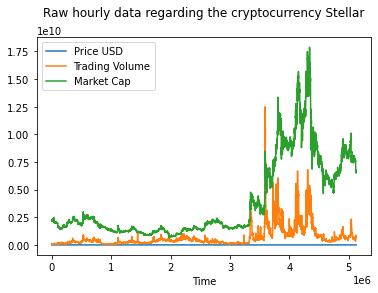

In [53]:
plt.title(f'Raw hourly data regarding the cryptocurrency {currency}\n')
plt.plot(price, label='Price USD')
plt.plot(vol, label='Trading Volume')
plt.plot(marketcap, label='Market Cap')
ticks = datetime[::100]
#plt.xticks(ticks)
plt.xlabel('Time')
plt.legend()

In [47]:
np.arange(0,len(datetime),100)

array([    0,   100,   200,   300,   400,   500,   600,   700,   800,
         900,  1000,  1100,  1200,  1300,  1400,  1500,  1600,  1700,
        1800,  1900,  2000,  2100,  2200,  2300,  2400,  2500,  2600,
        2700,  2800,  2900,  3000,  3100,  3200,  3300,  3400,  3500,
        3600,  3700,  3800,  3900,  4000,  4100,  4200,  4300,  4400,
        4500,  4600,  4700,  4800,  4900,  5000,  5100,  5200,  5300,
        5400,  5500,  5600,  5700,  5800,  5900,  6000,  6100,  6200,
        6300,  6400,  6500,  6600,  6700,  6800,  6900,  7000,  7100,
        7200,  7300,  7400,  7500,  7600,  7700,  7800,  7900,  8000,
        8100,  8200,  8300,  8400,  8500,  8600,  8700,  8800,  8900,
        9000,  9100,  9200,  9300,  9400,  9500,  9600,  9700,  9800,
        9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700,
       10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600,
       11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500,
       12600, 12700,

In [18]:
# From the above chart, the number range is too large (**1e10**), so we will use the log scale instead.
feats=np.dstack([np.log(price[1:] + 1),np.log(vol[1:] + 1),np.log(marketcap[1:] + 1)])[0,:,:]

print(feats.shape)

(23907, 3)


#  Data scaling

Note that we are using LSTM, **NOT** an ARIMA model. We don't have to remove the trend, sesonality, and cyclicity from the data. Yet, we still need to process the data by data scaling.

* Robust scaler: Helps removing outliers
* Min-max normalisation: Scale all features between 0-1: model performs better when numerical input variables are scaled to a standard range

In [19]:
# Data scaling
# Robust scaler: Helps removing outliers
scaler = RobustScaler()
# Min-max normalisation: Scale all features between 0-1: model performs better when numerical input variables are scaled to a standard range
scaler2 = MinMaxScaler()

feats_scaled = scaler2.fit_transform(scaler.fit_transform(feats))
print(feats_scaled)

[[0.14211855 0.11708727 0.3672111 ]
 [0.14188603 0.12124256 0.36684163]
 [0.1430799  0.12651471 0.36873441]
 ...
 [0.40518686 0.50564134 0.70679707]
 [0.40453634 0.49359046 0.70631799]
 [0.40561021 0.48193059 0.70710853]]


In [20]:
# Compared to unscaled below, which has a much larger range -> many data points appears as outliers
feats

array([[ 0.10848416, 18.32920716, 21.50971241],
       [ 0.10835836, 18.35236185, 21.50848805],
       [ 0.1090043 , 18.38174006, 21.51476032],
       ...,
       [ 0.2508166 , 20.49436319, 22.63502831],
       [ 0.25046464, 20.42721158, 22.63344073],
       [ 0.25104566, 20.36223881, 22.63606042]])

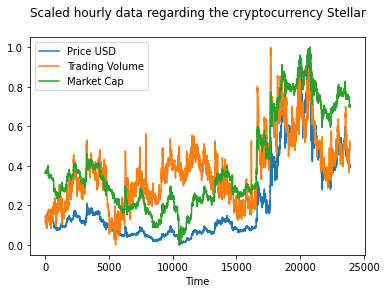

In [60]:
# Plot scaled features
plt.title(f'Scaled hourly data regarding the cryptocurrency {currency}\n')
plt.xlabel('Time')
plt.plot(feats_scaled,label=('Price USD','Trading Volume','Market Cap'))
plt.legend()

In [121]:
# Determine best sliding window size
# size: 3 * 7 => last three days
sliding_window = np.lib.stride_tricks.sliding_window_view(feats_scaled, (5 * 7 + 3 ,3), axis=(0,1))
sliding_window = sliding_window.reshape((sliding_window.shape[0], sliding_window.shape[2], sliding_window.shape[3]))

# Xs: Price, volume, market cap and price of the past week
Xs = np.array([i[:-3] for i in sliding_window])
# Xs: Price of the next three hours
Ys = np.array([i[-3:,0] for i in sliding_window])

print('-----------------------\nXs:\n')
print(Xs)
print('-----------------------\nYs:\n')
print(Ys)
print('-----------------------\nXs:\n')
print(Xs.shape)
print('-----------------------\nYs:\n')
print(Ys.shape)

-----------------------
Xs:

[[[0.14211855 0.11708727 0.3672111 ]
  [0.14188603 0.12124256 0.36684163]
  [0.1430799  0.12651471 0.36873441]
  ...
  [0.14473905 0.11869073 0.3713566 ]
  [0.14469951 0.11600263 0.37129457]
  [0.14517726 0.11634764 0.37204334]]

 [[0.14188603 0.12124256 0.36684163]
  [0.1430799  0.12651471 0.36873441]
  [0.13976798 0.13035038 0.36345719]
  ...
  [0.14469951 0.11600263 0.37129457]
  [0.14517726 0.11634764 0.37204334]
  [0.14483455 0.10062515 0.37150637]]

 [[0.1430799  0.12651471 0.36873441]
  [0.13976798 0.13035038 0.36345719]
  [0.13919871 0.13399596 0.36254171]
  ...
  [0.14517726 0.11634764 0.37204334]
  [0.14483455 0.10062515 0.37150637]
  [0.14445257 0.1041338  0.37090689]]

 ...

 [[0.45203777 0.3657207  0.73984305]
  [0.44435679 0.37352423 0.73461181]
  [0.44647332 0.37718095 0.7360602 ]
  ...
  [0.39486206 0.51207059 0.69912238]
  [0.40029538 0.51482557 0.70318008]
  [0.40265334 0.5118771  0.70492789]]

 [[0.44435679 0.37352423 0.73461181]
  [0.446

# Data splitting
We will use the holdout method. The split percentages are 90% for training, 5% for validation, 


and 5% for test.

**TODO: Visualise splits**

We first bifurcate Train+Validation VS Test, then divide Train from Validation by choosing random chunks like the following:

`
splits = get_splits(y, valid_size=.2, stratify=True, random_state=23, shuffle=True)
splits
`

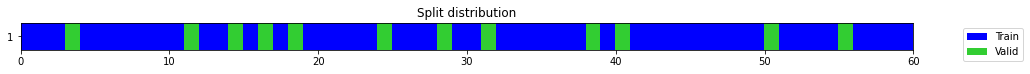

Reference: https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/00c_Time_Series_data_preparation.ipynb#scrollTo=207JZDz657T4

In [ ]:
TrainAndValLen = int(len(Xs) * 0.90)
TestLen = len(Xs) - TrainLen

x_train = Xs[0:TrainAndValLen,:]
y_train = Ys[0:TrainAndValLen]

x_val = Xs[TrainLen:ValLen,:]
y_val = Ys[TrainLen:ValLen]

x_test = Xs[ValLen:,:]
y_test = Ys[ValLen:]

y_train = y_train.reshape((y_train.shape[0],y_train.shape[1],1))
y_val = y_val.reshape((y_val.shape[0],y_val.shape[1],1))
y_test = y_test.reshape((y_test.shape[0],y_test.shape[1],1))

In [122]:
TrainLen = int(len(Xs) * 0.90)
ValLen = int(len(Xs) * 0.95)
TestLen = len(Xs) - TrainLen

x_train = Xs[0:TrainLen,:]
y_train = Ys[0:TrainLen]

x_val = Xs[TrainLen:ValLen,:]
y_val = Ys[TrainLen:ValLen]

x_test = Xs[ValLen:,:]
y_test = Ys[ValLen:]

y_train = y_train.reshape((y_train.shape[0],y_train.shape[1],1))
y_val = y_val.reshape((y_val.shape[0],y_val.shape[1],1))
y_test = y_test.reshape((y_test.shape[0],y_test.shape[1],1))

In [123]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(21483, 35, 3)
(1193, 35, 3)
(1194, 35, 3)
(21483, 3, 1)
(1193, 3, 1)
(1194, 3, 1)


# Distributed learning
## Introducing allreduce

Reminder of some deep learning concepts:
* Gradient descent: 
* Backpropagation: 

**allreduce** is a type of algorithm that combines gradients across different workers. This algorithm aggregates gradient values from different workers by, for example, summing them and then copying them to different workers. Its implementation can be very efficient as it reduces the overhead involved in synchronizing the gradients. Many allreduce algorithm implementations are available, depending on the types of communication available between workers and on the architecture's topology.

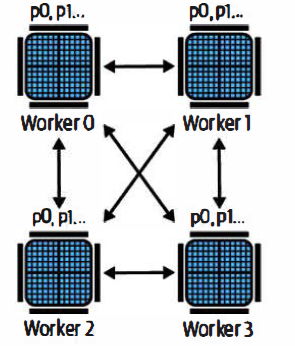

## How ringallreduce works

Ring-allreduce is the most common implementation of the allreduce algorithm, which is used by the Hovorod library and the`tf.distribute.MirroredStrategy` class provided by TensorFlow. Each worker sends its gradient to its successor on the ring and receives a gradient from its predecessor. **Eventually, each worker receives a copy of the combined gradients.**
Why ring-allreduce? Ring-allreduce **uses network bandwidth optimally, because it uses both the upload and download bandwidth of each worker**. It's fast whether working with multiple workers on a single machine or a small number of machines.
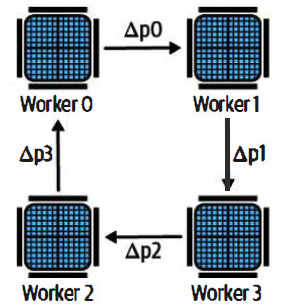

In [124]:
model = Sequential()
model.add(LSTM(128, dropout=0.05, return_sequences=True))
model.add(LSTM(64, dropout=0.05))
model.add(Dense(3, activation='sigmoid'))

# Adam optimiser allows high learning rate at first and speeds up training
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Early stop to prevent overfitting
callbackEs = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3, verbose=1, restore_best_weights=True)

# Log performance using TensorBoard
callbackTb = tf.keras.callbacks.TensorBoard()

model.fit(x_train, y_train, shuffle=True, epochs=500, verbose=2, validation_data=(x_val, y_val), callbacks = [callbackTb, callbackEs])

Epoch 1/500
672/672 - 20s - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 2/500
672/672 - 18s - loss: 6.0714e-04 - mean_squared_error: 6.0714e-04 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 3/500
672/672 - 17s - loss: 5.3700e-04 - mean_squared_error: 5.3700e-04 - val_loss: 4.1605e-04 - val_mean_squared_error: 4.1605e-04
Epoch 4/500
672/672 - 17s - loss: 4.2758e-04 - mean_squared_error: 4.2758e-04 - val_loss: 2.1271e-04 - val_mean_squared_error: 2.1271e-04
Epoch 5/500
672/672 - 17s - loss: 4.3823e-04 - mean_squared_error: 4.3823e-04 - val_loss: 8.8360e-04 - val_mean_squared_error: 8.8360e-04
Epoch 6/500
672/672 - 16s - loss: 3.9180e-04 - mean_squared_error: 3.9180e-04 - val_loss: 4.2191e-04 - val_mean_squared_error: 4.2191e-04
Epoch 7/500
672/672 - 16s - loss: 3.8327e-04 - mean_squared_error: 3.8327e-04 - val_loss: 1.7119e-04 - val_mean_squared_error: 1.7119e-04
Epoch 8/500
672/672 - 16s - loss: 3.5307e-04 - mean_square

In [125]:
i = model.predict(x_test)
predicted = np.ravel(i)

print(i)
print(y_test)

print(i.shape)
print(y_val.shape)
'''
for x_test:
    model.predict()
'''

[[0.3869437  0.38602996 0.3852152 ]
 [0.38967046 0.3886673  0.38789734]
 [0.39162987 0.39060897 0.3898238 ]
 ...
 [0.39650887 0.39559197 0.39472145]
 [0.39989766 0.39895806 0.3981503 ]
 [0.39823046 0.39735413 0.39653456]]
[[[0.39576685]
  [0.39774465]
  [0.39144962]]

 [[0.39774465]
  [0.39144962]
  [0.39457139]]

 [[0.39144962]
  [0.39457139]
  [0.38828655]]

 ...

 [[0.40677995]
  [0.40257796]
  [0.40518686]]

 [[0.40257796]
  [0.40518686]
  [0.40453634]]

 [[0.40518686]
  [0.40453634]
  [0.40561021]]]
(1194, 3)
(1193, 3, 1)


'\nfor x_test:\n    model.predict()\n'

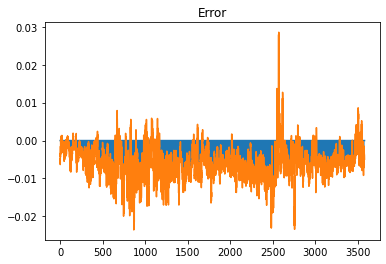

In [126]:
predicted2 = np.ravel(i)
y_test2 = np.ravel(y_test)

plt.title('Error (Difference between Predicted Value and Ground Truth)')
# Apply inverse transform to cancel the effects of MinMax scaler and Robust scaler to get back the original
error = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:,0] - scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test2]))[:, 0]
plt.plot(np.arange(len(error)), [0] * len(error))
plt.plot(error)
plt.fill_between(np.arange(len(error)), [0] * len(error), error)

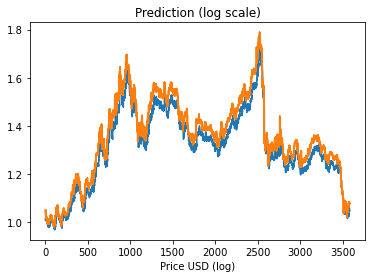

In [127]:
predicted3 = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:,0].ravel()
y_test3 = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test2]))[:,0].ravel()

plt.title('Prediction (log scale)')
plt.xlabel('Price USD (log)')
plt.plot(predicted3,label="predict")
plt.plot(y_test3,label="real")

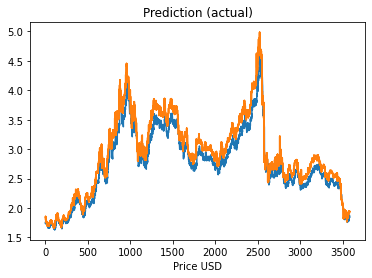

In [128]:
# Undo the log to see the actual price in USD
predicted0 = np.exp(predicted3)-1
y_test0 = np.exp(y_test3)-1

plt.title('Prediction (actual)')
plt.xlabel('Price USD')
plt.plot(predicted0,label="predict")
plt.plot(y_test0,label="real")

In [83]:
for _ in range(100):
    print('--------------------------------------------------------------------')

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
----------------------------------

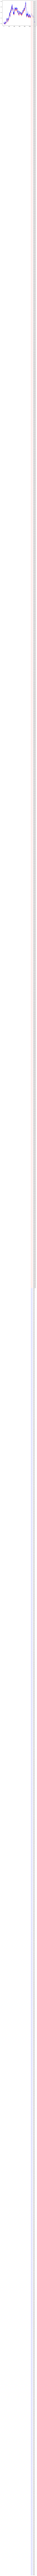

In [129]:
i3 = scaler2.inverse_transform([[x,0,0] for x in predicted2])[:,0].reshape(i.shape)
y_test3 = scaler2.inverse_transform([[x,0,0] for x in y_test2])[:,0].reshape(y_test.shape)

from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
for x in range(len(i3)):
    plt.plot(np.arange(x,x+3), i3[x],'r--',label="predict")
for x1 in range(len(y_test)):
    plt.plot(np.arange(x1,x1+3), y_test3[x1],'b-',label="real")
plt.legend()

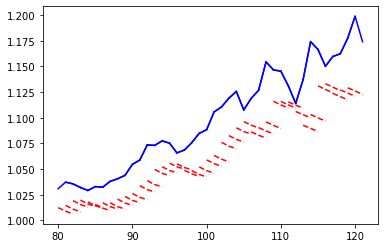

In [130]:
for x in range(80,120):
    plt.plot(np.arange(x,x+3), i3[x],'r--',label="predict")
    plt.plot(np.arange(x,x+3), y_test3[x],'b-',label="real")

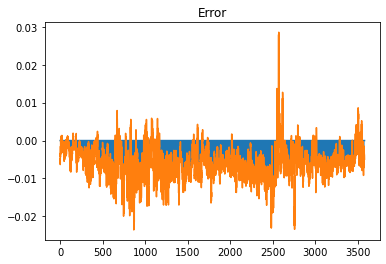

In [131]:
predicted2 = np.ravel(i)
y_test2 = np.ravel(y_test)

plt.title('Error')
error = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:,0] - scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test2]))[:, 0]
plt.plot(np.arange(len(error)), [0] * len(error))
plt.plot(error)
plt.fill_between(np.arange(len(error)), [0] * len(error), error)

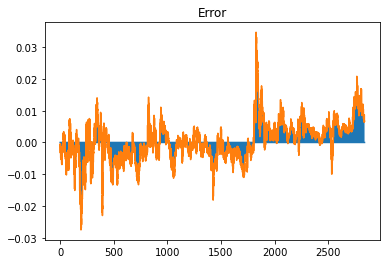

In [119]:
predicted2 = np.ravel(i)
y_test2 = np.ravel(y_test)

plt.title('Error')
error = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:,0] - scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test2]))[:, 0]
plt.plot(np.arange(len(error)), [0] * len(error))
plt.plot(error)
plt.fill_between(np.arange(len(error)), [0] * len(error), error)

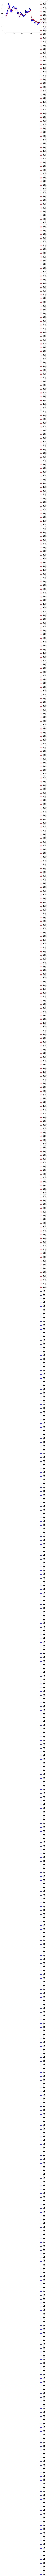

In [122]:
i3 = scaler2.inverse_transform([[x,0,0] for x in predicted2])[:,0].reshape(i.shape)
y_test3 = scaler2.inverse_transform([[x,0,0] for x in y_test2])[:,0].reshape(y_test.shape)

from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
for x in range(len(i3)):
    plt.plot(np.arange(x,x+3), i3[x],'r--',label="predict")
for x1 in range(len(y_test)):
    plt.plot(np.arange(x1,x1+3), y_test3[x1],'b-',label="real")
plt.legend()

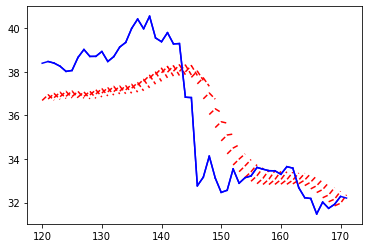

In [138]:
for x in range(120,170):
    plt.plot(np.arange(x,x+3), i3[x],'r--',label="predict")
    plt.plot(np.arange(x,x+3), y_test3[x],'b-',label="real")

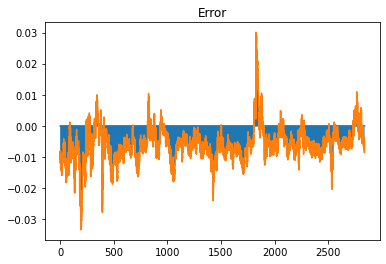

In [83]:
predicted2 = np.ravel(i)
y_test2 = np.ravel(y_test)

plt.title('Error')
error = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:,0] - scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test2]))[:, 0]
plt.plot(np.arange(len(error)), [0] * len(error))
plt.plot(error)
plt.fill_between(np.arange(len(error)), [0] * len(error), error)

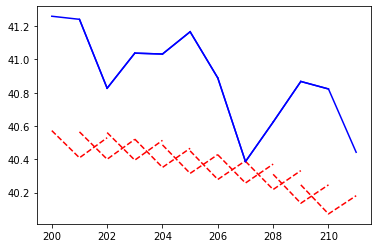

In [124]:
for x in range(200,210):
    plt.plot(np.arange(x,x+3), i3[x],'r--',label="predict")
    plt.plot(np.arange(x,x+3), y_test3[x],'b-',label="real")

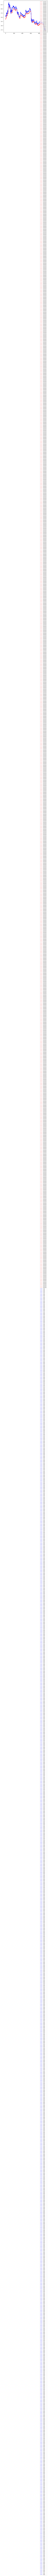

In [86]:
i3 = scaler2.inverse_transform([[x,0,0] for x in predicted2])[:,0].reshape(i.shape)
y_test3 = scaler2.inverse_transform([[x,0,0] for x in y_test2])[:,0].reshape(y_test.shape)

from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
for x in range(len(i3)):
    plt.plot(np.arange(x,x+3), i3[x],'r--',label="predict")
for x1 in range(len(y_test)):
    plt.plot(np.arange(x1,x1+3), y_test3[x1],'b-',label="real")
plt.legend()

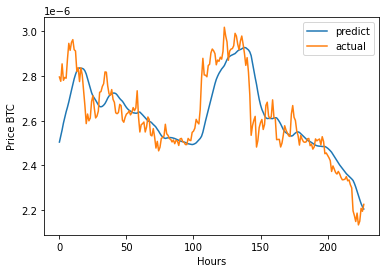

In [793]:
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted]))[:,0], label='predict')
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test]))[:, 0], label='actual')
plt.xlabel('Hours')
plt.ylabel('Price BTC')
plt.legend()

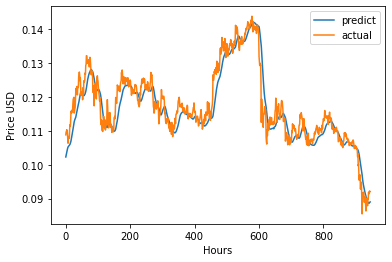

In [851]:
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted]))[:,0], label='predict')
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test]))[:, 0], label='actual')
plt.xlabel('Hours')
plt.ylabel('Price USD')
plt.legend()

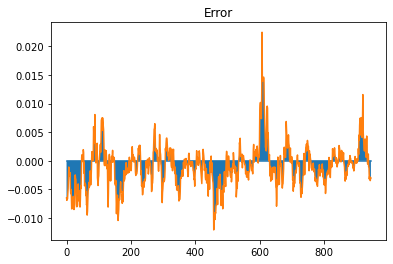

In [859]:
plt.title('Error')
error = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted]))[:,0] - scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test]))[:, 0]
plt.plot(np.arange(len(error)), [0] * len(error))
plt.plot(error)
plt.fill_between(np.arange(len(error)), [0] * len(error), error)

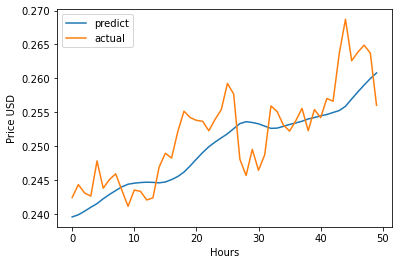

In [958]:
#plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in np.array(a[-946:])]))[:,0], label='predict')
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:50,0], label='predict')
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test]))[:50, 0], label='actual')
plt.xlabel('Hours')
plt.ylabel('Price USD')
plt.legend()